In [1]:
# Define networks
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math

class CTRNN(nn.Module):
    """Continuous-time RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms. 
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()
        
    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.
        
        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)
        
        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        
        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        input_projection = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)
            input_projection.append(self.input2h(input[i]))

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        input_projection = torch.stack(input_projection, dim=0)  
        
        return output, hidden, input_projection


class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
    
    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Continuous time RNN
        self.rnn = CTRNN(input_size, hidden_size, **kwargs)
        
        # Add an output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, hidden, input_projection = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output, input_projection
    
    
    

/Users/jacobtanner/anaconda3/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
/Users/jacobtanner/anaconda3/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


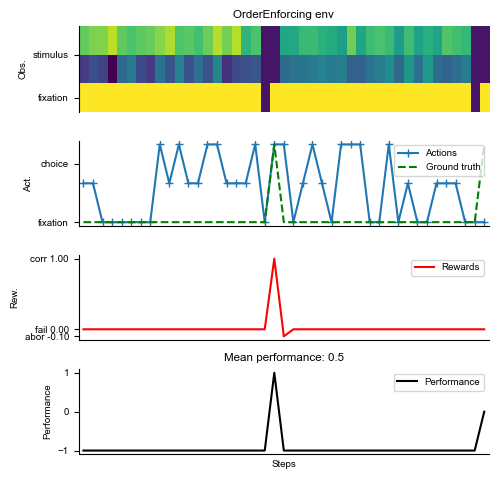

In [2]:

import neurogym as ngym

# Environment
task = 'PerceptualDecisionMaking-v0'
kwargs = {'dt': 100}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n



In [3]:


import torch.optim as optim

# Instantiate the network and print information
hidden_size = 100
net = RNNNet(input_size=input_size, hidden_size=hidden_size,
             output_size=output_size, dt=env.dt)
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

running_loss = 0
running_acc = 0
for i in range(500):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # in your training loop:
    optimizer.zero_grad()   # zero the gradient buffers
    output, _,_ = net(inputs)
    output = output.view(-1, output_size)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()    # Does the update

    running_loss += loss.item()
    if i % 100 == 99:
        running_loss /= 100
        print('Step {}, Loss {:0.4f}'.format(i+1, running_loss))
        running_loss = 0
        
        

RNNNet(
  (rnn): CTRNN(
    (input2h): Linear(in_features=3, out_features=100, bias=True)
    (h2h): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc): Linear(in_features=100, out_features=3, bias=True)
)
Step 100, Loss 0.1771
Step 200, Loss 0.0226
Step 300, Loss 0.0199
Step 400, Loss 0.0151
Step 500, Loss 0.0139


In [4]:


import scipy.io as sio

import numpy as np
env.reset(no_step=True)
perf = 0
num_trial = 100
activity_dict = {}
trial_infos = {}
all_inputs = []
all_outputs = []
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity,_ = net(inputs)
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity
    trial_infos[i] = gt
    all_inputs.append(inputs.detach().numpy())
    all_outputs.append(action_pred.detach().numpy())
# Concatenate activity for PCA
activity = np.concatenate(list(activity_dict[i] for i in range(num_trial)), axis=0)
print('Shape of the neural activity: (Time points, Neurons): ', activity.shape)


mdic = {"activity": activity}

sio.savemat("data/activity_pdm.mat", mdic)

mdic = {"all_inputs": all_inputs}

sio.savemat("data/all_inputs_pdm.mat", mdic)
    
    
mdic = {"all_outputs": all_outputs}

sio.savemat("data/all_outputs.mat", mdic)


IW = net.rnn.input2h.weight.detach().numpy()

mdic = {"IW": IW}

sio.savemat("data/IW.mat", mdic)



Shape of the neural activity: (Time points, Neurons):  (2200, 100)


In [72]:



# Save entire model
torch.save(net, 'good_RNN_perc_dm.pth')


In [27]:


net = torch.load('C:/Users/Jacob/RNN+input+projections/Figure 1- Module functions/good_RNN_perc_dm.pth')



Shape of the neural activity: (Time points, Neurons):  (2200, 100)
Trial  0 {'ground_truth': 0, 'coh': 25.6}
Trial  1 {'ground_truth': 0, 'coh': 0.0}
Trial  2 {'ground_truth': 0, 'coh': 12.8}
Trial  3 {'ground_truth': 1, 'coh': 12.8}
Trial  4 {'ground_truth': 1, 'coh': 12.8}


Text(0, 0.5, 'PC 2')

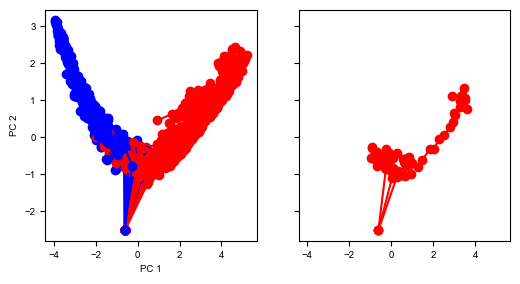

In [5]:

import numpy as np
env.reset(no_step=True)
perf = 0
num_trial = 100
activity_dict = {}
trial_infos = {}
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity,_ = net(inputs)
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity
    trial_infos[i] = env.trial
    
# Concatenate activity for PCA
activity = np.concatenate(list(activity_dict[i] for i in range(num_trial)), axis=0)
print('Shape of the neural activity: (Time points, Neurons): ', activity.shape)


mdic = {"activity": activity}

sio.savemat("data/activity.mat", mdic)

# Print trial informations
for i in range(5):
    print('Trial ', i, trial_infos[i])
# Compute PCA and visualize
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(activity)
# print('Shape of the projected activity: (Time points, PCs): ', activity_pc.shape)

import matplotlib.pyplot as plt


task_idd = np.zeros(num_trial)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(6, 3))
for i in range(num_trial):
    activity_pc = pca.transform(activity_dict[i])
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 0 else 'blue'
    
    task_idd[i] = 1 if trial['ground_truth'] == 0 else 2
    
    _ = ax1.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)
    
    if i < 3:
        _ = ax2.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)

ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')





(100, 16)


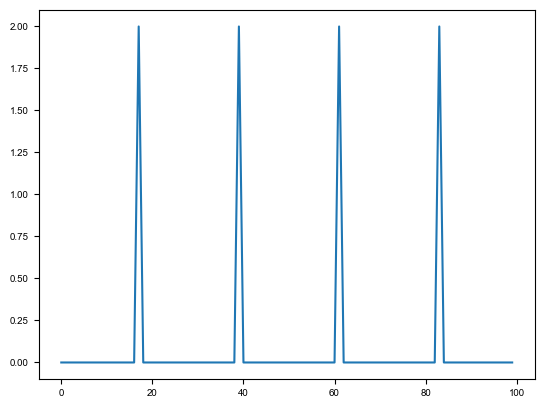

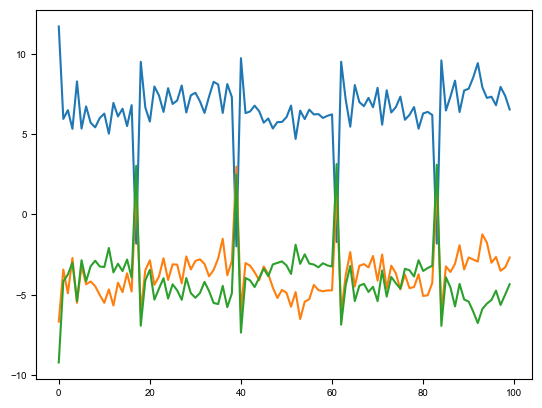

In [43]:
inputs, labels = dataset()
inputs = torch.from_numpy(inputs).type(torch.float)
#labels = torch.from_numpy(labels.flatten()).type(torch.long)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output, _,_ = net(inputs)


o = output[:,0].detach().numpy()
l = labels[:,0]

print(labels.shape)


plt.plot(l)
plt.show()
plt.plot(o)
plt.show()

In [6]:

def get_flow(model,input_sequence,pca_result,nbins,seq_length,create_movie,plot_it):
    # Create flow diagram to see transient dynamics

    #Create a grid in the 2D PCA space
    x_vals = np.linspace(min(pca_result[:, 0])-2, max(pca_result[:, 0])+2, nbins)
    y_vals = np.linspace(min(pca_result[:, 1])-2, max(pca_result[:, 1])+2, nbins)

    grid_points_pca = np.array([[x, y] for x in x_vals for y in y_vals])



    # Project points back to original space
    grid_points_original = pca.inverse_transform(grid_points_pca)

    # Convert to tensor
    grid_points_original = torch.tensor(grid_points_original, dtype=torch.float)


    # ...

    # Initialize empty list to store the trajectories for each initial hidden state
    all_trajectories = []
    all_traj_original = []
    # Iterate through each initial hidden state in the grid
    for init_hidden in grid_points_original:
        # Initialize hidden state
        hidden = init_hidden.unsqueeze(0).unsqueeze(0)  # Add sequence and batch dimensions

        # Create input sequence (all zeros)
        #input_sequence = torch.zeros(sequence_length, 1, input_size)  # Single sequence

        # Store the evolution of this specific initial hidden state
        trajectories = []
        trajectories.append(hidden[:,0,:].squeeze().detach().numpy())
        # Evolve the hidden state
        for t in range(seq_length):
            hidden = model.rnn.recurrence(input_sequence, hidden)
            #net.rnn.recurrence
            #print(hidden.shape)
            trajectories.append(hidden[:,0,:].squeeze().detach().numpy())
        trajectories = np.array(trajectories)
        #print(trajectories.shape)
        # Transform the trajectory to PCA space for easy visualization
        trajectories_pca = pca.transform(trajectories)

        # Save this trajectory
        all_trajectories.append(trajectories_pca)
        all_traj_original.append(trajectories)

    # Convert to numpy array for easier indexing
    all_trajectories = np.array(all_trajectories)
    all_traj_original = np.array(all_traj_original)
    
    if plot_it == "yes":
        # Plotting in PCA space
        fig, ax = plt.subplots()
        
      

        

         # Choose some time steps to plot
        #time_steps_to_plot = range(0, seq_length - 1, 5)  # Until sequence_length - 1 because we'll look at next steps

        t = 0
        #for t in time_steps_to_plot:
        x_vals = all_trajectories[:, t, 0]  # First principal component at time t
        y_vals = all_trajectories[:, t, 1]  # Second principal component at time t
        
        # Create the scatter plot
        x = np.squeeze(all_trajectories[:,0,0])
        y = np.squeeze(all_trajectories[:,0,1])

        sc = ax.scatter(x, y, s=np.zeros(625), c=np.zeros(625), cmap='Greys', alpha=0.5)
        plt.colorbar(sc)
        # Compute differences to plot as vectors
        dx = all_trajectories[:, t + 1, 0] - x_vals
        dy = all_trajectories[:, t + 1, 1] - y_vals

        ax.quiver(x_vals, y_vals, dx, dy, angles='xy') #, scale_units='xy', scale=1

        ax.legend()
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title('RNN Hidden State Flow Diagram in PCA Space (Quiver Plot)')
        plt.show()
    
    
    if create_movie == "yes":
        from matplotlib.animation import FuncAnimation

        # ...

        # Your existing code to generate all_trajectories goes here

        # ...

        fig, ax = plt.subplots()
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title('RNN Hidden State Flow Diagram in PCA Space (Quiver Plot)')

        # Initialize a quiver plot
        Q = ax.quiver(x_vals, y_vals, dx, dy, angles='xy', label=f'Time {t}') #, scale_units='xy', scale=1
        
        all_quivers = []
        
        def init():
            # Initialize empty quiver data
            Q.set_UVC(x_vals, y_vals)
            Q.set_offsets([])
            return Q,

        def update(t):
            # Set quiver data for frame t
            x_vals = all_trajectories[:, t, 0]
            y_vals = all_trajectories[:, t, 1]
            dx = all_trajectories[:, t + 1, 0] - x_vals
            dy = all_trajectories[:, t + 1, 1] - y_vals
            Q.set_UVC(dx, dy)
            Q.set_offsets(np.column_stack((x_vals, y_vals)))
            return Q, 
        
        '''def update(t):
            global all_trajectories  # Since we're modifying it
            global all_quivers  # Declare it as global so that we can modify it

            # Extract current positions
            x_vals = all_trajectories[:, t, 0]
            y_vals = all_trajectories[:, t, 1]

            # Compute differences to plot as vectors
            dx = all_trajectories[:, t + 1, 0] - x_vals
            dy = all_trajectories[:, t + 1, 1] - y_vals

            all_quivers.append((x_vals.copy(), y_vals.copy(), dx.copy(), dy.copy()))

            # Concatenate all quivers to plot them all at the current frame
            all_x_vals = np.concatenate([q[0] for q in all_quivers])
            all_y_vals = np.concatenate([q[1] for q in all_quivers])
            all_dx = np.concatenate([q[2] for q in all_quivers])
            all_dy = np.concatenate([q[3] for q in all_quivers])

            # Clear the existing quivers
            ax.clear()

            # Create a new quiver plot with the updated positions and vectors
            Q = ax.quiver(all_x_vals, all_y_vals, all_dx, all_dy, angles='xy', scale_units='xy', scale=1)

            return Q,'''

        # Create animation
        ani = FuncAnimation(fig, update, frames=range(0, seq_length - 1), init_func=init, blit=True)

        # To view the animation inline (may not work in all environments)
        from IPython.display import HTML
        HTML(ani.to_jshtml())

        # Or save it
        ani.save('rnn_flow.mp4', writer='ffmpeg')

        plt.show()

    
    return all_trajectories, all_traj_original 





In [7]:






import torch
import copy

def lesion_rnn(model, neuron_index):
    """
    Lesion an RNN model at the given neuron index.

    Parameters:
    - model (torch.nn.Module): The PyTorch RNN model to lesion.
    - neuron_index (int): The index of the neuron to lesion.

    Returns:
    - torch.nn.Module: A new PyTorch RNN model with the specified neuron lesioned.
    """

    # Clone the original model
    lesioned_model = copy.deepcopy(model)



    # Lesion the weights for the neuron in the hidden-to-hidden transition
    lesioned_model.rnn.h2h.weight.data[neuron_index, :] = 0.0
    lesioned_model.rnn.h2h.weight.data[:, neuron_index] = 0.0
    # Lesion the biases for the neuron in the hidden layer
    lesioned_model.rnn.h2h.bias.data[neuron_index] = 0.0


    return lesioned_model

def create_lesioned_models(model,num_neurons):
    """
    Create a list of lesioned RNN models, one for each neuron in the hidden layer.

    Parameters:
    - model (torch.nn.Module): The original PyTorch RNN model.

    Returns:
    - list: A list of lesioned PyTorch RNN models.
    """

    lesioned_models = []

    for i in range(num_neurons):
        lesioned_model = lesion_rnn(model, i)
        lesioned_models.append(lesioned_model)

    return lesioned_models



# Create a list of lesioned models
lesioned_models = create_lesioned_models(net,100)

# Now, `lesioned_models` contains 20 RNN models, each with one of the neurons in the hidden layer lesioned.


In [9]:


# Compute PCA and visualize
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(activity)
# print('Shape of the projected activity: (Time points, PCs): ', activity_pc.shape)


activity_pc = pca.transform(activity)


nbins = 25

input_sequence = np.tile([1, 0, 0], (2, 1))
input_sequence = torch.tensor(input_sequence, dtype=torch.float32)

seq_length = 1

create_movie = "no"
plot_it = "no"
all_quivers = []
all_trajectories_real, orig_real = get_flow(net,input_sequence,activity_pc,nbins,seq_length,create_movie,plot_it)

print(orig_real.shape)

def euclidean_distance(p, q):
    return np.linalg.norm(np.array(p) - np.array(q))

S = all_trajectories_real.shape
print(S)
diff = np.zeros([625,100])
diff2 = np.zeros([625,100])
total = np.zeros(100)
for i in range(100):

    all_trajectories, orig = get_flow(lesioned_models[i],input_sequence,activity_pc,nbins,seq_length,create_movie,plot_it)
    differ = np.zeros(S[0])
    differ2 = np.zeros(S[0])
    for num in range(S[0]):    
        differ[num] = euclidean_distance(all_trajectories_real[num,1,:], all_trajectories[num,1,:])
        differ2[num] = euclidean_distance(orig_real[num,1,:], orig[num,1,:])
    diff[:,i] = differ
    diff2[:,i] = differ2

    print(np.sum(differ))
    
    total[i] = np.sum(differ)
    




(625, 2, 100)
(625, 2, 2)
9.983287213799485e-06
17.996300924336538
257.1682278048247
23.321473743766546
6.676679318945389
0.0
0.0
0.0
163.07768500223756
2.8930727768165525
2.7351271549705416
8.620019614892954
2.732364223411423
267.87123747565784
0.0
98.0679237106815
0.0
30.293436205014586
0.0
48.68262824918202
0.0
0.0
26.486741385422647
0.0
0.0
284.7795522038359
90.92542278021574
72.8379518892616
255.33965400276065
8.94072145386599
7.727412496830311
0.0
0.0
0.0
40.26943739131093
1.8243355854747278
0.0
0.0
0.0
68.60820142924786
0.0
0.0
0.0
8.071582879056223
1.0545384236174868
0.0
6.495405733119696
145.36747022531927
3.095285874152978
0.0
0.0
0.0
955.6938011473976
3.5637855258537456
0.45965562300807505
0.0
695.3820575475693
60.34049516171217
0.0
0.42365319260716205
2.860750322470267
420.65770065784454
0.0
0.0
6.350806565256789
0.0
923.9136137552559
0.0
0.0
0.0
0.0
204.42291670691975
10.525852366758045
18.57295569622147
665.0869250115356
0.0
4.179943510396697
799.8028601889964
0.0
1.81155

C:\Users\Jacob\AppData\Local\Temp\ipykernel_9028\3344462605.py:54: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


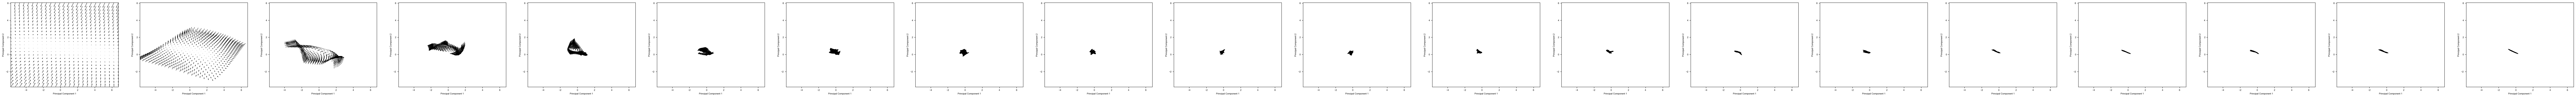

In [12]:


seq_length = 20

create_movie = "no"
plot_it = "no"
all_quivers = []
all_trajectories_real = get_flow(net,input_sequence,activity_pc,nbins,seq_length,create_movie,plot_it)

x = np.squeeze(all_trajectories_real[:,0,0])
y = np.squeeze(all_trajectories_real[:,0,1])


# Using a colormap (e.g., 'viridis', 'plasma', 'inferno', etc.)
#colormap = plt.cm.plasma
fig, axs = plt.subplots(1, seq_length, figsize=(7*seq_length, 4.8))
min_x_value = np.min(x)
min_y_value = np.min(y)

max_y_value = np.max(y) 
max_x_value = np.max(x)  #min_x_value + (max_y_value-min_y_value)-1

for ax in axs:
    ax.set_aspect('equal', 'box')
    ax.set_xlim([min_x_value, max_x_value])
    ax.set_ylim([min_y_value, max_y_value])
for i in range(seq_length):
    # Create the scatter plot
    
    
    #axs[i].set_aspect('equal', 'box')
    

    
    #sc = axs[i].scatter(x, y, c=np.zeros(625), cmap="Greys", alpha=0.5,vmin=0,vmax = 1)

    # Add a colorbar
    #axs[i].colorbar(sc)
    t = i
    #for t in time_steps_to_plot:
    x_vals = all_trajectories_real[:, t, 0]  # First principal component at time t
    y_vals = all_trajectories_real[:, t, 1]  # Second principal component at time t

    # Compute differences to plot as vectors
    dx = all_trajectories_real[:, t + 1, 0] - x_vals
    dy = all_trajectories_real[:, t + 1, 1] - y_vals

    axs[i].quiver(x_vals, y_vals, dx, dy, angles='xy', label=f'Time {t}') #, scale_units='xy', scale=1


    axs[i].set_xlabel('Principal Component 1')
    axs[i].set_ylabel('Principal Component 2')
    #axs[i].title('RNN Hidden State Flow Diagram in PCA Space (Quiver Plot)')
    
fig.savefig('figs/frame_by_frame_flow.pdf')
fig.show()



C:\Users\Jacob\AppData\Local\Temp\ipykernel_9028\2191866193.py:63: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


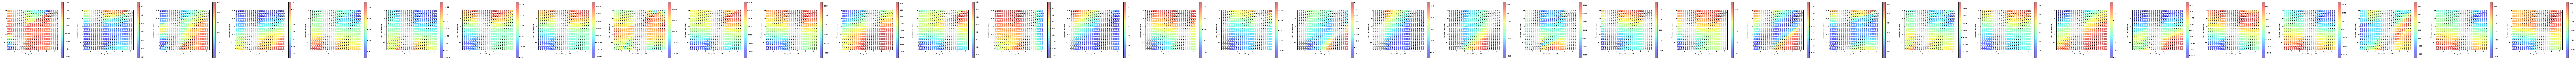

In [15]:


import scipy
import scipy.io

x = np.squeeze(all_trajectories_real[:,0,0])
y = np.squeeze(all_trajectories_real[:,0,1])



# Load the .mat file
mat_data = scipy.io.loadmat('C:/Users/Jacob/RNN+input+projections/Figure 1- Module functions/data/modules.mat')

# mat_data is a dictionary with variable names as keys and loaded matrices as values
modules = mat_data['modules']

MM = modules[:,1+1]

f = np.nonzero(MM)


fig, axs = plt.subplots(1, len(f[0]), figsize=(6.4*len(f[0]), 4.8))
min_x_value = np.min(x)
min_y_value = np.min(y)

max_y_value = np.max(y) 
max_x_value = np.max(x)  #min_x_value + (max_y_value-min_y_value)-1

for ax in axs:
    ax.set_aspect('equal', 'box')
    ax.set_xlim([min_x_value, max_x_value])
    ax.set_ylim([min_y_value, max_y_value])
    
for i in range(len(f[0])):
    heatmap_values = np.squeeze(np.sum(diff[:,:,f[0][i]],axis = 1))

    # Using a colormap (e.g., 'viridis', 'plasma', 'inferno', etc.)
    colormap = plt.cm.jet

    # Create the scatter plot
    sc = axs[i].scatter(x, y, c=heatmap_values, cmap=colormap, alpha=0.5)

    # Add a colorbar
    #axs[i].set_colorbar(sc)
    cbar = fig.colorbar(sc, ax=axs[i])
    t = 0
    #for t in time_steps_to_plot:
    x_vals = all_trajectories_real[:, t, 0]  # First principal component at time t
    y_vals = all_trajectories_real[:, t, 1]  # Second principal component at time t

    # Compute differences to plot as vectors
    dx = all_trajectories_real[:, t + 1, 0] - x_vals
    dy = all_trajectories_real[:, t + 1, 1] - y_vals

    axs[i].quiver(x_vals, y_vals, dx, dy, angles='xy', label=f'Time {t}') #, scale_units='xy', scale=1


    axs[i].set_xlabel('Principal Component 1')
    axs[i].set_ylabel('Principal Component 2')
    #axs[i].title('RNN Hidden State Flow Diagram in PCA Space (Quiver Plot)')



fig.savefig('figs/lesion_flow_all.pdf')
fig.show()



In [1]:



import numpy as np
import scipy.io as sio

lesion_sim = np.zeros([100,100])

for i in range(100):
    for j in range(100):
        
        one = diff2[:,i]
        two = diff2[:,j]
        
        r = np.corrcoef(one,two)
        lesion_sim[i,j] = r[0,1]
        

plt.imshow(lesion_sim)
plt.show()



mdic = {"lesion_sim": lesion_sim}

sio.savemat("data/lesion_sim.mat", mdic)




idd = np.nansum(lesion_sim,axis = 0) != 0



mdic = {"activity": activity}

sio.savemat("data/activity.mat", mdic)

FC = np.corrcoef(activity.T)
SC = net.rnn.h2h.weight.detach().numpy()

les = lesion_sim[idd,:]
les2 = les[:,idd]
FC = FC[:,idd]
FC = FC[idd,:]
SC = SC[:,idd]
SC = SC[idd,:]

idd = np.nansum(FC,axis = 0) != 0
print(les2.shape)
print(FC.shape)
print(SC.shape)
print(idd.shape)

les2 = les2[idd,:]
les2 = les2[:,idd]
FC = FC[:,idd]
FC = FC[idd,:]
SC = SC[:,idd]
SC = SC[idd,:]


print(np.sum(np.isnan(les2)))
print(np.sum(np.isnan(FC)))
print(np.sum(np.isnan(SC)))





print(np.corrcoef(FC.flatten(),les2.flatten()))

plt.plot(FC.flatten(),les2.flatten(),"r*")
plt.xlabel("Functional Connectivity")
plt.ylabel("Lesion effect similarity")
plt.show()


print(np.corrcoef(SC.flatten(),les2.flatten()))


NameError: name 'diff2' is not defined

In [75]:




def get_flow_with_real(model,input_sequence,pca_result,nbins,seq_length,real,task_indices):
    # Create flow diagram to see transient dynamics

    #Create a grid in the 2D PCA space
    x_vals = np.linspace(min(pca_result[:, 0])-2, max(pca_result[:, 0])+2, nbins)
    y_vals = np.linspace(min(pca_result[:, 1])-2, max(pca_result[:, 1])+2, nbins)

    grid_points_pca = np.array([[x, y] for x in x_vals for y in y_vals])



    # Project points back to original space
    grid_points_original = pca.inverse_transform(grid_points_pca)

    # Convert to tensor
    grid_points_original = torch.tensor(grid_points_original, dtype=torch.float)


    # ...

    # Initialize empty list to store the trajectories for each initial hidden state
    all_trajectories = []
    
    # Iterate through each initial hidden state in the grid
    for init_hidden in grid_points_original:
        # Initialize hidden state
        hidden = init_hidden.unsqueeze(0).unsqueeze(0)  # Add sequence and batch dimensions

        # Create input sequence (all zeros)
        #input_sequence = torch.zeros(sequence_length, 1, input_size)  # Single sequence

        # Store the evolution of this specific initial hidden state
        trajectories = []
        trajectories.append(hidden[:,0,:].squeeze().detach().numpy())
        # Evolve the hidden state
        for t in range(seq_length):
            hidden = model.rnn.recurrence(input_sequence, hidden)
            #net.rnn.recurrence
            #print(hidden.shape)
            trajectories.append(hidden[:,0,:].squeeze().detach().numpy())
        trajectories = np.array(trajectories)
        #print(trajectories.shape)
        # Transform the trajectory to PCA space for easy visualization
        trajectories_pca = pca.transform(trajectories)

        # Save this trajectory
        all_trajectories.append(trajectories_pca)

    # Convert to numpy array for easier indexing
    all_trajectories = np.array(all_trajectories)

    

     # Choose some time steps to plot
    time_steps_to_plot = range(0, seq_length - 1, 5)  # Until sequence_length - 1 because we'll look at next steps
    t = 0
    #for t in time_steps_to_plot:
    x_vals = all_trajectories[:, t, 0]  # First principal component at time t
    y_vals = all_trajectories[:, t, 1]  # Second principal component at time t

    # Create the scatter plot
    x = np.squeeze(all_trajectories[:,0,0])
    y = np.squeeze(all_trajectories[:,0,1])
    
    # Plotting in PCA space
    fig, ax = plt.subplots()
    
    min_x_value = np.min(x)
    min_y_value = np.min(y)

    max_y_value = np.max(y) 
    max_x_value = np.max(x)  #min_x_value + (max_y_value-min_y_value)-1

    
    ax.set_aspect('equal', 'box')
    ax.set_xlim([min_x_value, max_x_value])
    ax.set_ylim([min_y_value, max_y_value])


    sc = ax.scatter(x, y, s=np.zeros(625), c=np.zeros(625), cmap='Greys', alpha=0.5)
    plt.colorbar(sc)
        
    # Compute differences to plot as vectors
    dx = all_trajectories[:, t + 1, 0] - x_vals
    dy = all_trajectories[:, t + 1, 1] - y_vals

    ax.quiver(x_vals, y_vals, dx, dy, angles='xy') #, scale_units='xy', scale=1

    f = np.argwhere(task_indices==1)

    activity_pc = pca.transform(real[f[3][0]])

    ax.plot(activity_pc[1:21, 0], activity_pc[1:21, 1],"r")
    ax.plot(activity_pc[20, 0], activity_pc[20, 1],"r*",ms = 15)

    f = np.argwhere(task_indices==2)


    activity_pc = pca.transform(real[f[3][0]])


    ax.plot(activity_pc[1:21, 0], activity_pc[1:21, 1],"b")
    ax.plot(activity_pc[20, 0], activity_pc[20, 1],"b*",ms=15)


    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.legend()
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('RNN Hidden State Flow Diagram in PCA Space (Quiver Plot)')
    
    
    return all_trajectories





3


(22, 100)


No handles with labels found to put in legend.


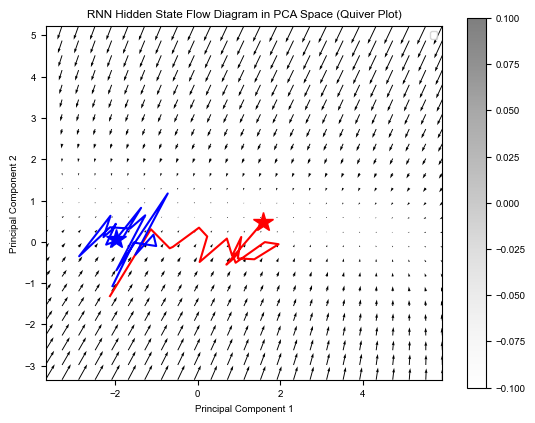

In [76]:






nbins = 25



seq_length = 2


real = activity_dict

print(real[0].shape)


input_sequence = np.tile([1, 0, 0], (2, 1))
input_sequence = torch.tensor(input_sequence, dtype=torch.float32)

all_trajectories = get_flow_with_real(net,input_sequence,activity_pc,nbins,seq_length,real,task_idd)


plt.savefig('figs/flow_with_real.pdf')
plt.show()
